# Cocoa price forecasting workflow (supervisor-ready)

This notebook follows the workflow outlined in the **WLL Cocoa Extension** proposal (hypothesis section intentionally omitted). Every step is arranged so you can run cells from top to bottom without editing code. The only requirement is that the repository dependencies are installed (see `requirements.txt`).

## 1. Quick start

1. Ensure the virtual environment is active and dependencies are installed: `pip install -r requirements.txt`.
2. Open this notebook (`notebooks/wll_cocoa_extension.ipynb`).
3. Click **Run All** in Jupyter. The notebook will load the processed dataset, train two quick baseline models, and produce plots.

All paths are pre-filled for the checked-in processed dataset (`data/processed/cocoa_ghana_full.csv`).

## 2. Imports and settings

- Adjust `OOS_START_DATE` only if you want to change the out-of-sample window.
- The feature and target lists are defined to match the processed data columns.

In [1]:
from pathlib import Path
import sys

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error


def find_project_root(start: Path) -> Path:
    """Walk up the tree until we find the project marker (pyproject)."""
    for candidate in (start, *start.parents):
        if (candidate / "pyproject.toml").exists():
            return candidate
    return start


PROJECT_ROOT = find_project_root(Path.cwd().resolve())
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

from cocoa.models.ml_models import RFModel, XGBModel

# Plotting style
plt.style.use('seaborn-v0_8')

DATA_PATH = PROJECT_ROOT / 'data' / 'processed' / 'cocoa_ghana_full.csv'
if not DATA_PATH.exists():
    raise FileNotFoundError(
        f"Processed dataset not found at {DATA_PATH}. "
        "Re-run the feature pipeline or update DATA_PATH."
    )

# Start date for out-of-sample evaluation
OOS_START_DATE = '2023-01-01'

FEATURE_COLS = [
    'PRCP_anom_mean', 'TAVG_anom_mean', 'PRCP_anom_std', 'TAVG_anom_std',
    'N_stations', 'log_price_lagt', 'log_return'
]
TARGET_COL = 'log_return_forecast_target'


## 3. Load and inspect the processed dataset

The cell below reads the processed Ghana cocoa panel, shows a preview, and reports the coverage period.

In [2]:
df = pd.read_csv(DATA_PATH, parse_dates=['date'])
print(f"Rows: {len(df):,} | Columns: {list(df.columns)}")
print(df.head())

print(f"\nDate range: {df['date'].min().date()} to {df['date'].max().date()}")

Rows: 6,734 | Columns: ['date', 'PRCP_anom_mean', 'TAVG_anom_mean', 'PRCP_anom_std', 'TAVG_anom_std', 'N_stations', 'log_price', 'log_price_lagt', 'log_return', 'log_return_forecast_target']
        date  PRCP_anom_mean  TAVG_anom_mean  PRCP_anom_std  TAVG_anom_std  \
0 1994-10-04          0.0000            0.25       0.000000       0.000000   
1 1994-10-05          0.0925            0.00       0.137886       2.828427   
2 1994-10-06          0.0040           -0.40       0.005657       0.565685   
3 1994-10-07         -0.0284            0.46       0.377151       1.306905   
4 1994-10-10         -0.4325           -4.00       0.000000       0.000000   

   N_stations  log_price  log_price_lagt  log_return  \
0           1   7.287752        7.290457   -0.002704   
1           2   7.265828        7.287752   -0.021924   
2           2   7.265653        7.265828   -0.000175   
3           5   7.255916        7.265653   -0.009737   
4           1   7.253987        7.255916   -0.001929   

   

## 4. Visualize price levels and returns

Two quick plots help confirm that the data load is working:
- Log price trend
- One-step-ahead log returns (target variable)


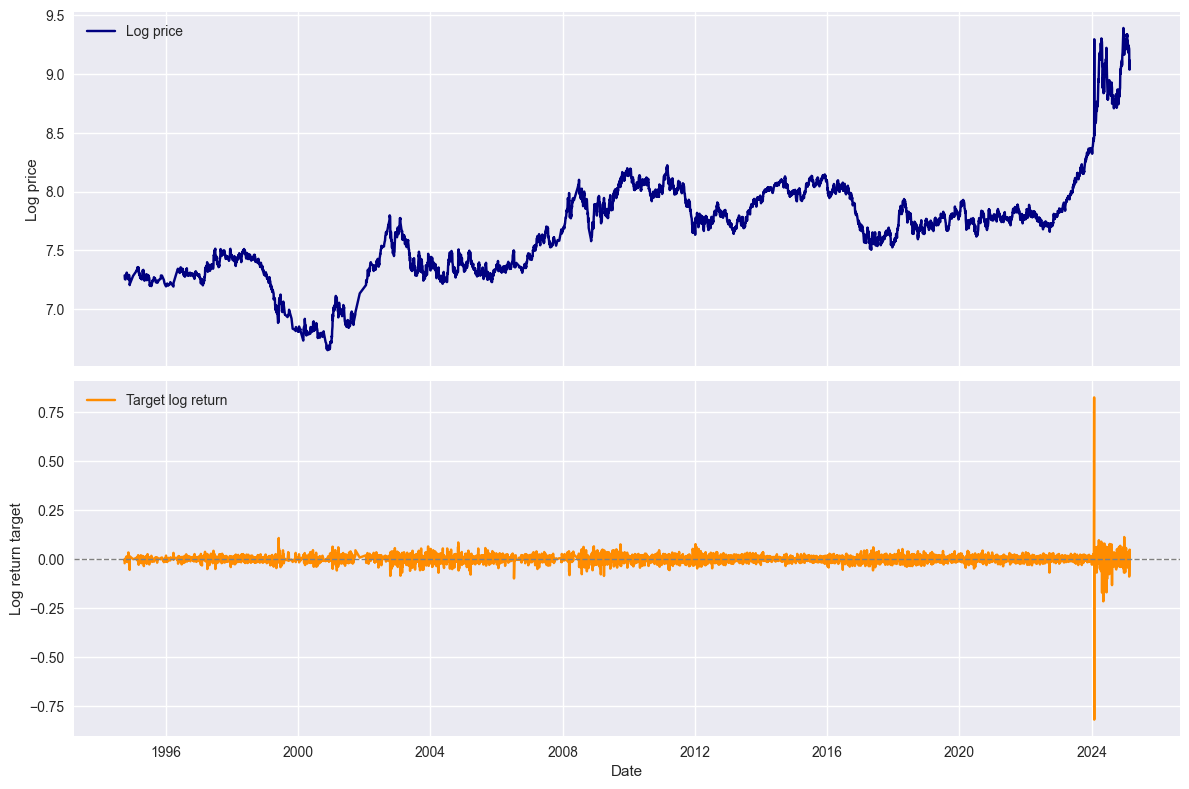

In [3]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
axes[0].plot(df['date'], df['log_price'], label='Log price', color='navy')
axes[0].set_ylabel('Log price')
axes[0].legend()

axes[1].plot(df['date'], df[TARGET_COL], label='Target log return', color='darkorange')
axes[1].axhline(0, color='gray', linestyle='--', linewidth=1)
axes[1].set_ylabel('Log return target')
axes[1].set_xlabel('Date')
axes[1].legend()

plt.tight_layout()
plt.show()

## 5. Train/test split

The split uses a calendar cut: everything before `OOS_START_DATE` is training data; later observations are held out for evaluation.

In [4]:
train_mask = df['date'] < pd.to_datetime(OOS_START_DATE)
test_mask = ~train_mask

train_df = df.loc[train_mask].copy()
test_df = df.loc[test_mask].copy()

X_train, y_train = train_df[FEATURE_COLS], train_df[TARGET_COL]
X_test, y_test = test_df[FEATURE_COLS], test_df[TARGET_COL]

print(f"Training rows: {len(X_train):,}")
print(f"Test rows: {len(X_test):,}")

Training rows: 6,186
Test rows: 548


## 6. Fit quick baseline models

Two models are run for comparison:
- **Random Forest**: fast nonlinear benchmark.
- **XGBoost**: gradient-boosted trees with modest parameters for quick execution.

Hyperparameters are intentionally lightweight so the notebook remains "click-and-run" friendly.

In [5]:
rf = RFModel(n_estimators=200, max_features=0.6, min_samples_leaf=2, random_state=42)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

xgb = XGBModel(
    n_estimators=250,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)


## 7. Evaluate and compare

Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) are reported for the out-of-sample period.

In [6]:
def summarize_metrics(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    return {'model': name, 'MAE': mae, 'RMSE': rmse}

results = [
    summarize_metrics('Random Forest', y_test, rf_pred),
    summarize_metrics('XGBoost', y_test, xgb_pred),
]

metrics_df = pd.DataFrame(results)
print(metrics_df)


           model       MAE      RMSE
0  Random Forest  0.026022  0.076588
1        XGBoost  0.025616  0.076077


## 8. Plot forecasts vs. actuals

The chart below overlays the two model forecasts against the target series for the evaluation window. A horizontal line at zero helps spot direction errors.

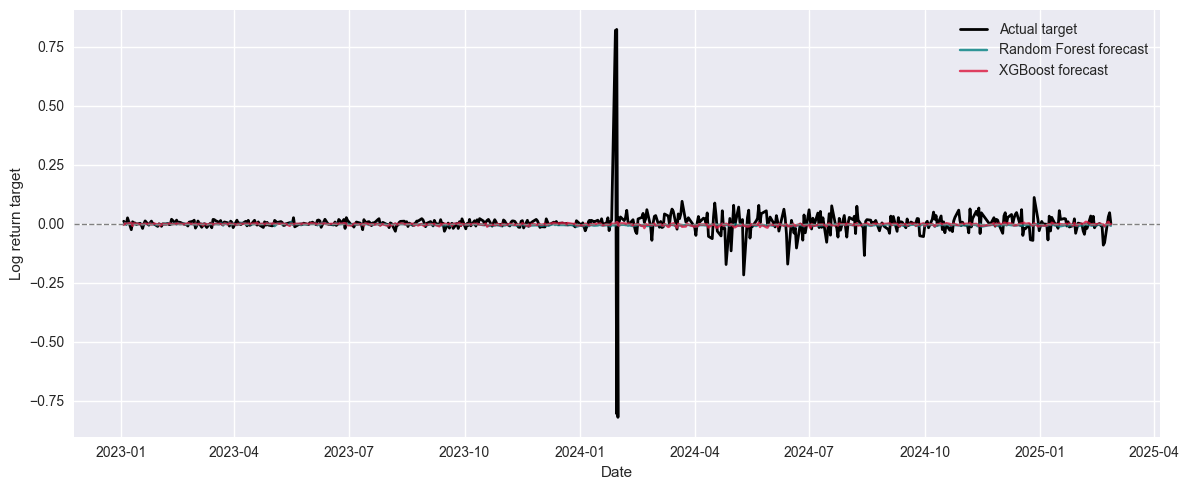

In [7]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(test_df['date'], y_test, label='Actual target', color='black', linewidth=2)
ax.plot(test_df['date'], rf_pred, label='Random Forest forecast', color='teal', alpha=0.8)
ax.plot(test_df['date'], xgb_pred, label='XGBoost forecast', color='crimson', alpha=0.8)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.set_ylabel('Log return target')
ax.set_xlabel('Date')
ax.legend()
plt.tight_layout()
plt.show()

## 9. Save quick-look outputs (optional)

If you want to keep the evaluation numbers and plot, uncomment the save lines below. Files will be written under `reports/`.


In [8]:
# Uncomment to save outputs
# output_dir = PROJECT_ROOT / 'reports'
# output_dir.mkdir(parents=True, exist_ok=True)
# metrics_df.to_csv(output_dir / 'wll_click_run_metrics.csv', index=False)
# fig_path = output_dir / 'wll_click_run_forecast.png'
# plt.savefig(fig_path, dpi=200)
# print(f"Saved metrics and plot to {output_dir}")